In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.autograd as autograd
from tqdm import tqdm
import seaborn as sns
import re
import datetime
import os
import random
import h3 
import shap 

c:\Users\Yuan\anaconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
h3_l7_df = pd.read_csv('h3_l7_df_new.csv')
h3_l7_df.drop(columns=['commercial;yes'], inplace=True)

train_index=[]
test_index=[]
for i in range(0,h3_l7_df.shape[0]):
    geo_location = h3.h3_to_geo(h3_l7_df.iloc[i]['id'])

    if (geo_location[1]) > (-76.05): #把經度大於-76.05的 當train (東邊是train)
        train_index.append(i)
    else:
        test_index.append(i)

# 分割訓練集和測試集
train_h3_l7_df = h3_l7_df.iloc[train_index]
test_h3_l7_df = h3_l7_df.iloc[test_index]

# 將 h3_l7_df 資料框中的 'id' 列移除，僅保留數據進行正規化
h3_spatial_data = h3_l7_df.drop('id', axis=1)


# # # 對數據進行正規化：將每個數據列的最小值調整為 0，最大值調整為 1
normalized_spatial_data = (h3_spatial_data - h3_spatial_data.min()) / (h3_spatial_data.max() - h3_spatial_data.min())

#設定OHCA正規化反函數 方便把預測結果返回原本scale
ohca_reguli_inverse = (h3_l7_df.ohca.max()-h3_l7_df.ohca.min()) + h3_l7_df.ohca.min()

# 將 DataFrame 轉換為 numpy array，並設定數據類型為 np.float64
spatial_data = np.array(normalized_spatial_data).astype(np.float64)


train_spatial_data = spatial_data[train_index]
test_spatial_data = spatial_data[test_index]

# 分离特征和标签
X = spatial_data[:, :-1]  # 特征
Y = spatial_data[:, -1]   # 标签（OHCA）

X_train_reguli = train_spatial_data[:, :-1] 
y_train_reguli = train_spatial_data[:, -1] 
X_test_reguli = test_spatial_data[:, :-1] 
y_test_reguli = test_spatial_data[:, -1] 


In [3]:
class Regressor(nn.Module):
    """
    用於迴歸任務的神經網絡模型 Regressor。
    
    結構:
    - 兩層隱藏層，並使用 ReLU 激活函數
    - 最後一層為線性層，不使用激活函數（適用於迴歸）
    """
    def __init__(self, input_size=2, hidden_size=32, output_size=1):
        super().__init__()
        # 定義三層全連接層
        self.fc1 = nn.Linear(input_size, hidden_size)     # 第一層：輸入層到隱藏層
        self.fc2 = nn.Linear(hidden_size, hidden_size)    # 第二層：隱藏層到隱藏層
        self.fc3 = nn.Linear(hidden_size, output_size)    # 第三層：隱藏層到輸出層

        # 初始化權重和偏置
        nn.init.normal_(self.fc1.weight, std=0.02)
        nn.init.constant_(self.fc1.bias, 0)
        nn.init.normal_(self.fc2.weight, std=0.02)
        nn.init.constant_(self.fc2.bias, 0)
        nn.init.normal_(self.fc3.weight, std=0.02)
        nn.init.constant_(self.fc3.bias, 0)
        
    def forward(self, input):
        # 前向傳播過程
        output = F.relu(self.fc1(input))  # 第一層 + ReLU 激活
        output = F.relu(self.fc2(output)) # 第二層 + ReLU 激活
        output = self.fc3(output)         # 第三層（不使用激活函數）
        return output

In [4]:
window_size = 1
seed = 123 #7890
torch.manual_seed(seed)
np.random.seed(seed)

def train_reg(spatial_data, 
              s_net,
              s_net_optim, 
              window_size, iter_num=5000):
    """
    訓練 s_net  網絡來預測 spatial_data 中的數據。
    
    參數:
    - spatial_data: numpy array，包含訓練數據
    - s_net: 神經網絡模型
    - s_net_optim: 優化器
    - window_size: 每次迭代的隨機取樣大小
    - iter_num: 訓練迭代次數
    
    返回:
    - loss_array: 每次迭代的損失值
    - t_fea_array, s_fea_array: 用於存儲特徵的暫時性陣列（目前未使用）
    """

    loss_array = []     # 儲存每次迭代的損失
    t_fea_array = []    # 預留用於儲存暫時性特徵的空列表
    s_fea_array = []    # 預留用於儲存暫時性特徵的空列表

    for _ in tqdm(range(iter_num)):
        
        # 隨機選擇一組數據索引
        h3_l7_id = np.random.choice(spatial_data.shape[0] - 1, window_size)


        # 提取目標變數（即輸入的最後一列數據）並轉為 Tensor
        ohca = spatial_data[h3_l7_id, -1].reshape(-1, 1)
        ohca = torch.autograd.Variable(torch.FloatTensor(ohca))

        # p_pred 用於預測目標變數
        p_pred = s_net(torch.autograd.Variable(torch.FloatTensor(spatial_data[h3_l7_id, :-1]))).reshape(-1, 1)

        # 定義均方誤差損失
        mseloss = torch.nn.MSELoss(reduction='sum')
        loss = mseloss(p_pred, ohca)
        
        # 清空前一次計算的梯度
        s_net_optim.zero_grad()
        
        
        # 計算損失的梯度
        autograd.backward(loss)

        # 更新神經網絡參數
        s_net_optim.step()
        
        # 儲存損失值
        loss_array.append(loss.detach().cpu().numpy())

    return loss_array, t_fea_array, s_fea_array

# 初始化模型和優化器
s_net = Regressor(input_size=spatial_data.shape[1] - 1, hidden_size=spatial_data.shape[1] * 2, output_size=1)
s_net_optim = optim.Adam(s_net.parameters(), lr=1e-4, weight_decay=1e-5)

iter_num=5000
# 執行訓練過程
loss_array, t_fea_array, s_fea_array = train_reg(train_spatial_data, s_net,
                                                 s_net_optim,
                                                 window_size, iter_num)

100%|██████████| 5000/5000 [00:07<00:00, 702.97it/s]


In [5]:
y_head_train = s_net(torch.autograd.Variable(torch.FloatTensor(train_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_train = train_spatial_data[:, -1]*ohca_reguli_inverse
y_head_test = s_net(torch.autograd.Variable(torch.FloatTensor(test_spatial_data[:, :-1]))).detach().numpy()*ohca_reguli_inverse
y_test = test_spatial_data[:, -1].reshape(-1, 1)*ohca_reguli_inverse

In [6]:
mae = np.abs(y_head_test-y_test)
ans_mae = mae.sum()/mae.shape[0]

print('MAE of test set= ',ans_mae)

# 計算殘差變異
ss_residual = np.sum((y_test - y_head_test) ** 2)

# 計算總變異量
ss_total = np.sum((y_test - np.mean(y_test)) ** 2)

# 計算 R²
r_squared = 1 - (ss_residual / ss_total)

n = mae.shape[0]          # Number of data points
p = train_spatial_data.shape[1]            # Number of predictors

# Adjusted R-squared calculation
r_squared_adj = 1 - (1 - r_squared) * (n - 1) / (n - p - 1)

print("R² of test set= ", r_squared)
print("ADJ R² of test set= ", r_squared_adj)

MAE of test set=  5.583852468018836
R² of test set=  0.7586561695152917
ADJ R² of test set=  2.0202261925035394


# SHAP

In [7]:
# 假設 `spatial_data` 包含背景數據，用於 SHAP 的解釋
background_data = torch.FloatTensor(train_spatial_data[:, :-1])  
test_data = torch.FloatTensor(test_spatial_data[:, :-1])  

# 建立 SHAP 解釋器，使用背景數據
explainer = shap.GradientExplainer(s_net, background_data)
shap_values_test = explainer.shap_values(test_data)*ohca_reguli_inverse
# Get the shap values from my test data

test_features_df = h3_spatial_data.iloc[:, :-1]
feature_names = test_features_df.columns

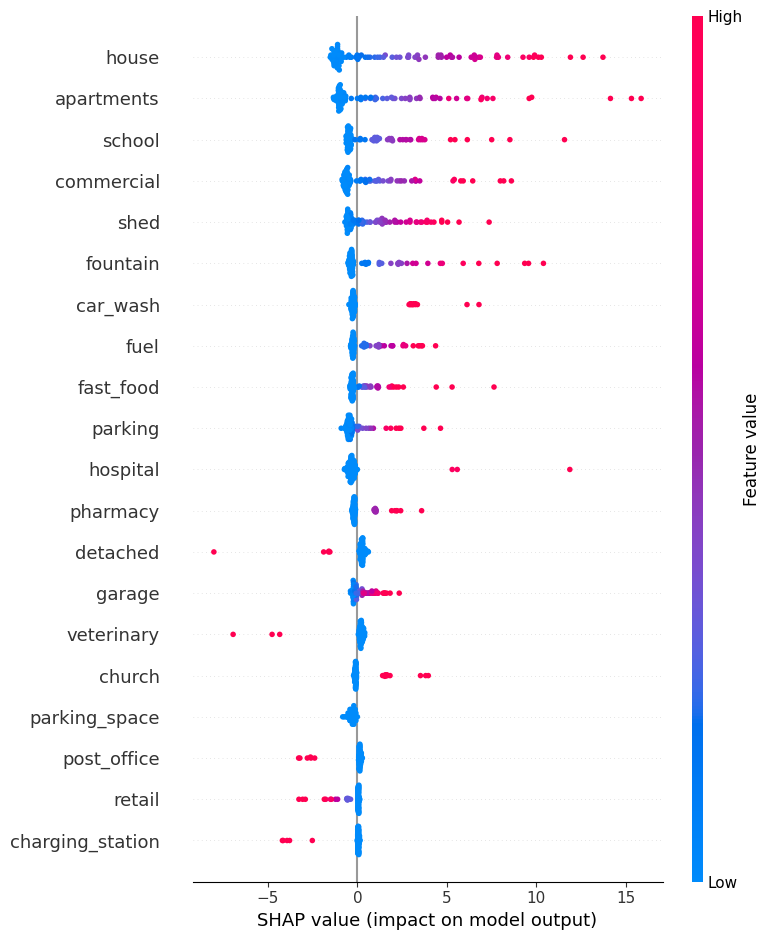

In [8]:
#把SHAP 換成壞圖之格式
shap_col = shap_values_test.shape[0]
shap_row = shap_values_test.shape[1]
shap_values_test_2D = shap_values_test.reshape(shap_col,shap_row)
shap.summary_plot(shap_values_test_2D, test_data,feature_names)

In [9]:
feature_names_w_SHAP = [f'shap {col}' for col in feature_names] # 在每個列名前加上 'shap'
SHAP_df = pd.DataFrame(shap_values_test_2D, columns=feature_names_w_SHAP) #換成 DF

In [10]:
df1 = test_h3_l7_df.reset_index(drop=True)
df2 = SHAP_df.reset_index(drop=True)
test_h3_l7_df_S = pd.concat([df1, df2], axis=1) #合併SHAP值到test_h3_l7_df

In [11]:
# 初始化結果 DataFrame
spatial_data_score = pd.DataFrame()
spatial_data_score['id'] = test_h3_l7_df_S['id']

# 初始化字典來存儲計算結果
results_dict = {}
# 逐列處理
for col in feature_names:
    col_result = []  # 存儲當前特徵的計算結果
    
    # 遍歷每一行
    for row in range(test_h3_l7_df_S.shape[0]):
        building_name = col
        shap_name = 'shap ' + building_name
        denominator = test_h3_l7_df_S.iloc[row][building_name] # 分母
        numerator = test_h3_l7_df_S.iloc[row][shap_name]  # 分子
        
        # 處理分母為 0 的情況
        if denominator == 0:
            col_result.append(numerator)
        else:
            col_result.append(numerator / denominator)

    # 將結果存入字典
    results_dict[col] = col_result

# 一次性加入所有計算結果
spatial_data_score = pd.concat([spatial_data_score, pd.DataFrame(results_dict)], axis=1)

In [12]:
spatial_data_score

,id,place_of_worship,grave_yard,school,post_office,childcare,university,courthouse,fire_station,library,...,cabin,warehouse,sports_centre,detached,boathouse,barn,riding_hall,construction,ship,ruins
0,872af0424ffffff,-0.098777,0.021613,-0.444379,0.141057,-0.064959,0.0,0.0,0.020957,0.021224,...,-1.481041e-36,0.0,0.008950,0.220296,-0.000550,-0.001014,-0.005864,-0.001518,0.008212,-0.015362
1,872af0425ffffff,-0.095136,0.013451,-0.505800,0.081147,-0.080584,0.0,0.0,0.010329,0.017388,...,-9.361057e-37,0.0,0.017723,0.236741,-0.001370,-0.000566,-0.004159,-0.001915,0.000000,-0.005111
2,872af0426ffffff,-0.107407,0.034722,-0.550778,0.118168,-0.074321,0.0,0.0,0.033572,0.036044,...,-2.462993e-36,0.0,0.070408,0.188957,-0.001527,-0.000259,-0.000611,-0.002840,0.008373,-0.013192
3,872af0502ffffff,-0.082268,0.012048,-0.344212,0.117663,-0.057848,0.0,0.0,0.020732,0.022660,...,-1.631904e-36,0.0,0.020953,0.127650,-0.001754,-0.000011,-0.000513,-0.005362,0.011748,-0.014642
4,872af0503ffffff,-0.095532,0.026381,-0.415681,0.138306,-0.054053,0.0,0.0,0.023644,0.026499,...,-1.980910e-36,0.0,0.058767,0.287788,-0.004658,-0.000533,-0.004941,-0.007261,0.025035,-0.033126
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
89,872af6370ffffff,0.061999,0.044378,-0.536680,0.200518,-0.059874,0.0,0.0,0.027317,0.029305,...,1.503192e-36,0.0,0.000000,0.239671,-0.001166,0.002101,0.005911,-0.247972,0.038153,-0.007975
90,872af6371ffffff,0.061966,0.039334,0.594110,0.188670,-0.109961,0.0,0.0,0.025244,0.029729,...,1.315127e-36,0.0,0.060231,0.153065,-0.002664,0.001955,0.002929,-0.002883,0.036505,-0.021408
91,872af6372ffffff,0.080403,0.025801,-0.388731,0.159535,1.001221,0.0,0.0,-0.164633,0.036829,...,-4.152808e-37,0.0,0.062848,0.306905,-0.001508,0.002098,0.004423,-0.006843,0.028077,-0.023734
92,872af6373ffffff,-0.075877,0.033536,-0.498911,0.149281,-0.107103,0.0,0.0,0.022042,0.036299,...,1.072006e-36,0.0,0.028140,0.349618,0.000000,0.001390,0.002933,-0.012645,0.008839,-0.020476


# 製造有SHAP值的poi_df

In [13]:
poi_df = pd.read_csv('poi_df.csv') #讀進原檔案
selected_values = spatial_data_score['id']
test_poi_df = poi_df[poi_df['h3_l7'].isin(selected_values)]

In [14]:
# Step 1: 將 spatial_data_score 的 wide-format 轉成 long-format
long_score_df = spatial_data_score.melt(
    id_vars='id',
    var_name='building',     # 建築類型欄
    value_name='score'       # 分數欄
)

# Step 2: 不預設 test_poi_df['score']，直接 merge
test_poi_df = test_poi_df.reset_index(drop=True)
test_poi_df = test_poi_df.merge(
    long_score_df,
    how='left',
    left_on=['h3_l7', 'building'],
    right_on=['id', 'building']
)

# Step 3: 清理合併後的中間欄位
test_poi_df.drop(columns=['id'], inplace=True)

# Step 4: 最後的 score 就是合併進來的，不會有 _x/_y 問題
test_poi_df


,osmid,lat,lon,h3_l7,building,score
0,356567877,36.709595,-76.047987,872af626dffffff,place_of_worship,0.052614
1,356567948,36.586005,-76.082863,872af051cffffff,place_of_worship,0.097847
2,356568033,36.733205,-76.097433,872af626effffff,place_of_worship,0.142201
3,356568069,36.557653,-76.073542,872af0519ffffff,place_of_worship,0.050911
4,356568361,36.850422,-76.160777,872af6353ffffff,place_of_worship,0.076309
...,...,...,...,...,...,...
99719,7485109,36.866139,-76.133943,872af6350ffffff,residential,-0.010563
99720,9637418,36.858806,-76.170325,872af622cffffff,house,-0.000272
99721,11674759,36.819752,-76.076312,872af634effffff,school,0.644480
99722,12032839,36.790276,-76.111886,872af6266ffffff,residential,-0.009411


In [15]:
def intersection_area(r1, r2, d):
    if d >= r1 + r2:
        return 0  # 兩圓不相交
    elif d <= abs(r1 - r2):
        return np.pi * min(r1, r2)**2  # 一圓包含另一圓
    else:
        # 使用公式計算相交面積
        term1 = r1**2 * np.arccos((d**2 + r1**2 - r2**2) / (2 * d * r1))
        term2 = r2**2 * np.arccos((d**2 + r2**2 - r1**2) / (2 * d * r2))
        term3 = 0.5 * np.sqrt((-d + r1 + r2) * (d + r1 - r2) * (d - r1 + r2) * (d + r1 + r2))
        return term1 + term2 - term3


In [16]:
import math
# 向量化 haversine 距離計算
def haversine_array(lat1, lon1, lat2_array, lon2_array):
    lat1, lon1 = map(math.radians, [lat1, lon1])
    lat2_array = np.radians(lat2_array)
    lon2_array = np.radians(lon2_array)
    
    dlat = lat2_array - lat1
    dlon = lon2_array - lon1
    
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2_array) * np.sin(dlon / 2)**2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    R = 6371.0
    return R * c

In [17]:
def cache_h3_centers(df, h3_col='h3_l7'):
    unique_h3 = df[h3_col].unique()
    h3_center_dict = {h: h3.h3_to_geo(h) for h in unique_h3}
    df['center_lat'] = df[h3_col].map(lambda h: h3_center_dict[h][0])
    df['center_lon'] = df[h3_col].map(lambda h: h3_center_dict[h][1])
    return df

test_poi_df = cache_h3_centers(test_poi_df)

In [18]:
def area_score(AED_location, AED_range):
    center_radius = 1.21

    distances = haversine_array(AED_location[0], AED_location[1], test_poi_df['lat'], test_poi_df['lon'])
    mask = (distances <= AED_range) & (test_poi_df['score'].notna())
    subset = test_poi_df.loc[mask].copy()
    subset['distance_to_AED'] = distances[mask]

    if subset.empty:
        return 0

    # 直接使用快取的中心點
    center_distances = haversine_array(
        AED_location[0], AED_location[1],
        subset['center_lat'], subset['center_lon']
    )

    intersection_areas = [intersection_area(AED_range, center_radius, d) for d in center_distances]
    proportions = np.array(intersection_areas) / (np.pi * center_radius ** 2)
    weighted_scores = subset['score'].values * proportions

    return weighted_scores.sum()


In [19]:
test_poi_df

,osmid,lat,lon,h3_l7,building,score,center_lat,center_lon
0,356567877,36.709595,-76.047987,872af626dffffff,place_of_worship,0.052614,36.716911,-76.057359
1,356567948,36.586005,-76.082863,872af051cffffff,place_of_worship,0.097847,36.592810,-76.088605
2,356568033,36.733205,-76.097433,872af626effffff,place_of_worship,0.142201,36.732443,-76.100027
3,356568069,36.557653,-76.073542,872af0519ffffff,place_of_worship,0.050911,36.557949,-76.085760
4,356568361,36.850422,-76.160777,872af6353ffffff,place_of_worship,0.076309,36.852906,-76.151429
...,...,...,...,...,...,...,...,...
99719,7485109,36.866139,-76.133943,872af6350ffffff,residential,-0.010563,36.871068,-76.139095
99720,9637418,36.858806,-76.170325,872af622cffffff,house,-0.000272,36.851591,-76.178996
99721,11674759,36.819752,-76.076312,872af634effffff,school,0.644480,36.821809,-76.065874
99722,12032839,36.790276,-76.111886,872af6266ffffff,residential,-0.009411,36.784231,-76.118092


In [20]:
from tqdm import tqdm

total_score_list = []
for index in tqdm(range(test_poi_df.shape[0]), desc="Calculating total_score"):
    lat, lon = test_poi_df.iloc[index]['lat'], test_poi_df.iloc[index]['lon']
    total_score = area_score((lat, lon), 1.21)
    # print(total_score)
    total_score_list.append(total_score)
    

test_poi_df['total_score'] = total_score_list

Calculating total_score: 100%|██████████| 99724/99724 [16:57<00:00, 97.99it/s] 


# OR input NN result only

In [21]:
test_h3_l7_df['y_head'] = y_head_test
h3_center_dict = {h: h3.h3_to_geo(h) for h in test_h3_l7_df['id']}
test_h3_l7_df['center_lat'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][0])
test_h3_l7_df['center_lon'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][1])

def area_score_mlp(AED_location, AED_range):
    center_radius = 1.21

    distances = haversine_array(AED_location[0], AED_location[1], test_h3_l7_df['center_lat'], test_h3_l7_df['center_lon'])
    mask = (distances <= AED_range * 2)
    subset = test_h3_l7_df.loc[mask].copy()
    subset['distance_to_AED'] = distances[mask]

    if subset.empty:
        return 0

    # 直接使用快取的中心點
    center_distances = haversine_array(
        AED_location[0], AED_location[1],
        subset['center_lat'], subset['center_lon']
    )

    intersection_areas = [intersection_area(AED_range, center_radius, d) for d in center_distances]
    proportions = np.array(intersection_areas) / (np.pi * center_radius ** 2)
    weighted_scores = subset['y_head'].values * proportions

    return weighted_scores.sum()

from tqdm import tqdm

total_score_list = []
for index in tqdm(range(test_poi_df.shape[0]), desc="Calculating total_score"):
    lat, lon = test_poi_df.iloc[index]['lat'], test_poi_df.iloc[index]['lon']
    total_score = area_score_mlp((lat, lon), 1.21)
    # print(total_score)
    total_score_list.append(total_score)

test_poi_df['total_score_mlp'] = total_score_list

C:\Users\Yuan\AppData\Local\Temp\ipykernel_25152\881026651.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df['y_head'] = y_head_test
C:\Users\Yuan\AppData\Local\Temp\ipykernel_25152\881026651.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_h3_l7_df['center_lat'] = test_h3_l7_df['id'].map(lambda h: h3_center_dict[h][0])
C:\Users\Yuan\AppData\Local\Temp\ipykernel_25152\881026651.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [ ]:
# test_poi_df.to_csv('test_poi_df_NNtotal.csv')